In [127]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from Dataset import *
from torchvision import transforms


In [128]:

# Function to parse video and extract frames around a specific timestamp
def extract_video_clip(video_path, target_timestamp, video_start_time,time_window=3):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None
    # Get video frame rate and total frame count
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame range for the +- time_window
    target_time = target_timestamp
    start_time = target_time - timedelta(seconds=time_window)
    end_time = target_time + timedelta(seconds=time_window)
    if start_time < video_start_time:
        start_time = video_start_time
    if end_time > video_start_time + timedelta(seconds=total_frames / fps):
        end_time = video_start_time + timedelta(seconds=total_frames / fps)
    # print(f"Target Time: {target_time}, Start Time: {start_time}, End Time: {end_time}")
    # Extract frames within the time range
    frames = []
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Calculate the timestamp for the current frame
        frame_time = video_start_time + timedelta(seconds=frame_index / fps)
        if start_time <= frame_time <= end_time:
            frames.append(frame)
        frame_index += 1
        if frame_time > end_time:
            break

    cap.release()
    return np.array(frames)

# Load Excel file
def load_excel_data(file_path):
    activation_df = pd.read_excel(file_path, sheet_name="Activation")
    non_activation_df = pd.read_excel(file_path, sheet_name="NonActivation")
    return activation_df, non_activation_df

# Function to process dataset and extract video clips
def process_dataset(video_dir, excel_file, output_dir, clip_save_dir, time_window=3):
    # Road the Excel data
    activation_df, non_activation_df = load_excel_data(excel_file)

    # Create directories for saving data
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(clip_save_dir, exist_ok=True)

    # Prepare data for activation and non-activation
    # all_data = []
    for df, label in [(activation_df, 1), (non_activation_df, 0)]:
        for _, row in tqdm(df.iterrows()):
            clip_timestamp = row["timestamp"]
            location = row["location"]
            # convert to datetime object
            clip_timestamp = datetime.strptime(clip_timestamp, "%Y%m%d_%H%M%S")
            # Match the video file with the timestamp
            for video_file in os.listdir(video_dir):
                video_start_timestamp = video_file[22:].split(".")[0]
                # convert to datetime object
                video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
                video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
                if video_start_timestamp <= clip_timestamp <= video_end_timestamp:
                    video_path = os.path.join(video_dir, video_file)
                    clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                    if os.path.exists(clip_save_path):
                        continue
                    # Extract video clip
                    frames = extract_video_clip(video_path, clip_timestamp, video_start_timestamp,time_window)
                    if frames is not None:
                        data = (frames, label, row["timestamp"], location)
                        # save the clip to the clip_save_dir
                        # clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                        torch.save(torch.tensor(frames), clip_save_path)



In [161]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
excel_file_path = r"D:\RiDAR_Data\2ndPHB\Video\Activation.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_df, non_activation_df = load_excel_data(excel_file_path)
excel_file_1 = r"D:\LiDAR_Data\2ndPHB\Video\HAWK Pedestrian Behavior.xlsx"
student_file = pd.read_excel(excel_file_1)

In [162]:
"""
Conbine the my labels and high school student labels
"""
student_activation_L = student_file.loc[(student_file.Bound == 'N') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
student_activation_R = student_file.loc[(student_file.Bound == 'S') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
# uniform the column names and data format
# combine Date column and Time column in student_activation_L and student_activation_R, and convert to YYYYMMDD_HHMMSS format
timestamp = student_activation_L['Date'].astype(str) + '_' + student_activation_L['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
# eliminate '-' in the timestamp
timestamp = timestamp.str.replace('-','')
student_activation_L.loc[:,'timestamp'] = timestamp
timestamp = student_activation_R['Date'].astype(str) + '_' + student_activation_R['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
student_activation_R.loc[:,'timestamp'] = timestamp
# combine student_activation_L and student_activation_R to activation_df
student_activation_L.loc[:, 'location'] = 'L'
student_activation_R.loc[:, 'location'] = 'R'
student_activation_L = student_activation_L.loc[:,['timestamp','location']]
student_activation_R = student_activation_R.loc[:,['timestamp','location']]
student_activation = pd.concat([student_activation_L, student_activation_R], axis=0)
activation_df = pd.concat([activation_df, student_activation], axis=0)
# filter duplicate rows
activation_df.drop_duplicates(inplace=True)

In [168]:
""" identify unvisited video files"""
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
total_video_list = os.listdir(video_dir)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
# activation record format: 20241204_224500
# identify the video files that are not in the excel file
total_record_list = activation_df["timestamp"].tolist() + non_activation_df["timestamp"].tolist()
# convert to timestamp
total_record_list = [datetime.strptime(record, "%Y%m%d_%H%M%S") for record in total_record_list]
total_record_list_ = []
for record in total_record_list:
    record = record - timedelta(minutes = record.minute % 5)
    record = record.replace(second = 0 )
    total_record_list_.append(record)
unique_record_list = list(set(total_record_list_))
unvisited_video_list = []
for video in total_video_list:
    video_start_timestamp = video[22:].split(".")[0]
    video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
    if video_start_timestamp not in unique_record_list:
        unvisited_video_list.append(video)
save_path = r'D:\LiDAR_Data\2ndPHB\Video\round2\unvisited_video_list.csv'
df = pd.DataFrame(unvisited_video_list)
df.to_csv(save_path, index = False)

In [189]:
w

250

450 780 250 150


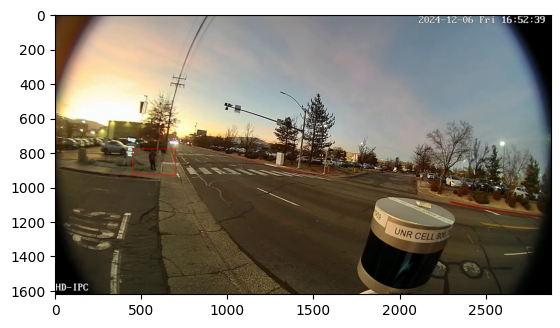

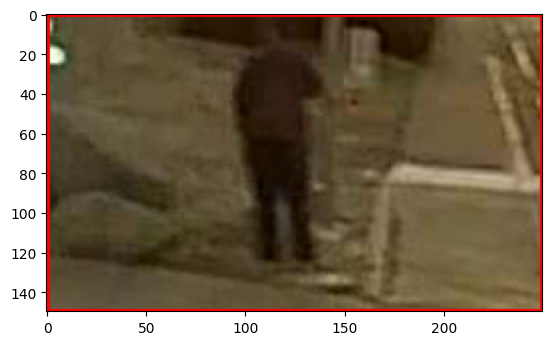

In [195]:
""" Select ROI for the video clips"""
video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train\1_20241206_165239_L.mp4'
cap = cv2.VideoCapture(video_path)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
cap.release()
frames = np.array(frames) # (seq_len, h, w, c)
test_img = frames[30].copy()
w,h = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+w, 780+h)
print(x,y,w,h)
cv2.rectangle(test_img, pt1_L, pt2_L, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[y:y+h, x:x+w]
plt.imshow(cropped_img)
plt.show()

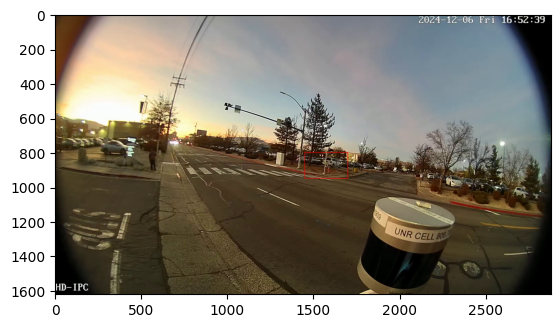

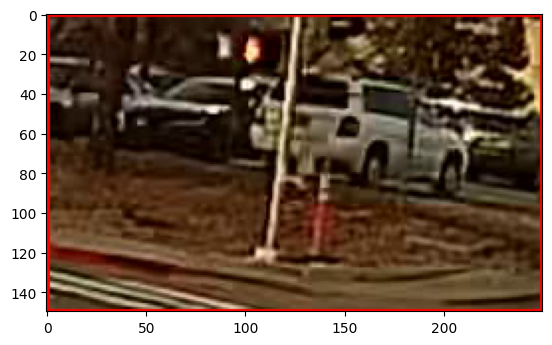

In [199]:
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+w, y+h)
test_img = frames[30].copy()
cv2.rectangle(test_img, pt1_R, pt2_R, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[y:y+h, x:x+w]
plt.imshow(cropped_img)
plt.show()

In [4]:
# Create directories for saving data
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(clip_save_dir, exist_ok=True)
time_window = 3 # seconds (30 frames)
# Prepare data for activation and non-activation
for df, label in [(activation_df, 1), (non_activation_df, 0)]:
    for _, row in tqdm(df.iterrows()):
        record_timestamp = row["timestamp"]
        location = row["location"]
        # convert to datetime object
        clip_timestamp = datetime.strptime(clip_timestamp, "%Y%m%d_%H%M%S")
        # Match the video file with the timestamp
        for video_file in os.listdir(video_dir):
            video_start_timestamp = video_file[22:].split(".")[0]
            # convert to datetime object
            video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
            video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
            if video_start_timestamp <= clip_timestamp <= video_end_timestamp:
                video_path = os.path.join(video_dir, video_file)
                clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                if os.path.exists(clip_save_path):
                    continue
                # Extract video clip
                frames = extract_video_clip(video_path, clip_timestamp, video_start_timestamp,time_window)
                if frames is not None:
                    data = (frames, label, row["timestamp"], location)
                    # save the clip to the clip_save_dir
                    clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.mp4")
                    out = cv2.VideoWriter(clip_save_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frames.shape[2], frames.shape[1]))
                    for frame in frames:
                        out.write(frame)
                    out.release()
# process_dataset(video_dir, excel_file, output_dir,clip_save_dir, time_window=3)

221it [47:08, 12.80s/it]
405it [1:25:28, 12.66s/it]


In [7]:
# Split the dataset into train, validation with 80% and 20% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
train_clips, val_clips = train_test_split(clips, test_size=0.2, random_state=714)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\R_signal\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\R_signal\val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
# Move the clips to the respective folders
for clip in train_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'R':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(train_folder, clip)
        os.rename(src, dst)
for clip in val_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'R':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(val_folder, clip)
        os.rename(src, dst)

In [8]:
# Split the dataset into train, validation with 80% and 20% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
train_clips, val_clips = train_test_split(clips, test_size=0.2, random_state=714)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
# Move the clips to the respective folders
for clip in train_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'L':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(train_folder, clip)
        os.rename(src, dst)
for clip in val_clips:
    # if the clip is right signal
    if clip.split('_')[-1][0] == 'L':
        src = os.path.join(clip_save_dir, clip)
        dst = os.path.join(val_folder, clip)
        os.rename(src, dst)

In [4]:
from Model import ResNetLSTM,ResNetLSTMWithAttention
from Dataset import VideoDataset,custom_transform,create_data_loaders
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import *
from torchvision import models
from MotionAppearanceFusion import TwoStreamModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [5]:
def create_data_loaders(train_dir, val_dir, batch_size=8, transform=None, augmentation_dict=None):
    train_dataset = VideoDataset(train_dir, transform=transform, augmentation_dict=augmentation_dict)
    val_dataset = VideoDataset(val_dir, transform=transform)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader
augmentation_dict = {"brightness": 0.5, "contrast": 0.5, "saturation": 0.5, "hue": 0.5,'h_flip':0.5, 'noise': 0.2}
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
train_loader, val_loader = create_data_loaders(train_dir, val_dir, batch_size=2, transform=custom_transform, augmentation_dict=augmentation_dict)

In [6]:
for i, (frames,optical_flow_frames, label, location) in enumerate(train_loader):
    break

In [161]:
pt1 = (450, 750)
pt2 = (750, 950)
x,y,w,h = pt1[0],pt1[1],pt2[0]-pt1[0],pt2[1]-pt1[1]
# Load video frames
video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train\1_20241206_165239_L.mp4'
def extract_optical_flow(x, y, w, h, video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_frame = prev_frame[y:y+h,x:x+w]
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    optical_flow_frames = []
# Loop through video frames
    while True:
        ret, next_frame = cap.read()
        if not ret:
            break
        next_frame = next_frame[y:y+h,x:x+w]
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, next_gray, None, 
            0.5, 3, 15, 3, 5, 1.2, 0
        )
    # Compute magnitude and angle
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Normalize the magnitude for better visualization
        normalized_magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
        optical_flow = np.concatenate([magnitude[..., None], angle[..., None]], axis=-1)
        # Save or append the result
        optical_flow_frames.append(optical_flow)
        
    # Update previous frame
        prev_gray = next_gray
    cap.release()
    return optical_flow_frames

optical_flow_frames = extract_optical_flow(x, y, w, h, video_path)

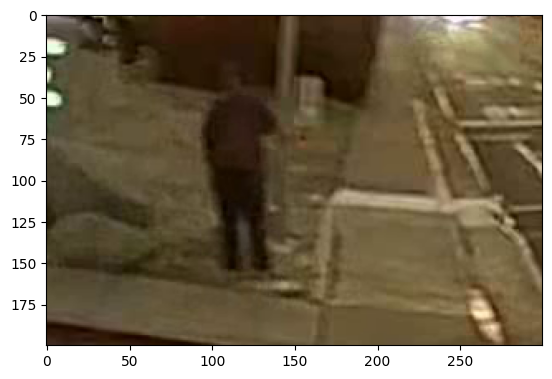

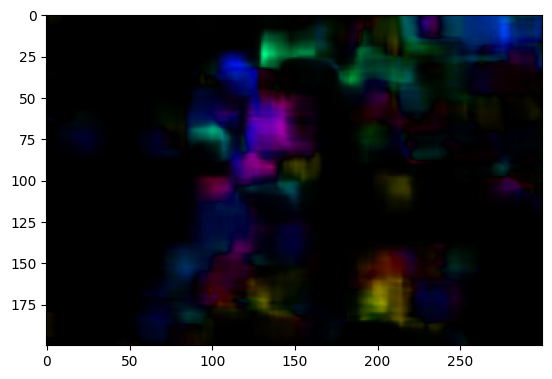

In [158]:
ind = 30
plt.imshow(frames[ind][y:y+h,x:x+w])
plt.show()
plt.imshow(optical_flow_frames[ind])
plt.show()

In [137]:
from sklearn.metrics import confusion_matrix
model_path = r"D:\LiDAR_Data\2ndPHB\Video\left_signal\model\best_model.pth"
# model = ResNetLSTMWithAttention().to(device)
model = CNNLSTMAttention().to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
# calculate the confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            # outputs = model(inputs)
            outputs = torch.flatten(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidence_thresholds = np.arange(0.1, 0.9, 0.1)
precision_scores = []
recall_scores = []
F1_scores = []

for threshold in confidence_thresholds:
    y_pred_thresholded = (y_pred > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    F1 = 2 * precision * recall / (precision + recall)

    precision_scores.append(precision)
    recall_scores.append(recall)
    F1_scores.append(F1)


Validation: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]
C:\Users\zhChe\AppData\Local\Temp\ipykernel_42500\2649136877.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])


In [141]:
recall_scores

[1.0, 1.0, 0.90625, 0.8125, 0.78125, 0.59375, 0.21875, 0.0]

In [139]:
precision_scores

[0.5245901639344263,
 0.5925925925925926,
 0.6170212765957447,
 0.6341463414634146,
 0.6756756756756757,
 0.6785714285714286,
 1.0,
 nan]

In [10]:
import random
import torch.nn.functional as F
def random_brightness_adjustment(frames, brightness_factor_range=(0.5, 1.5)):
    adjusted_frames = []
    brightness_factor = random.uniform(*brightness_factor_range)
    for frame in frames:
        frame = F.adjust_brightness(F.to_pil_image(frame.astype(np.uint8)), brightness_factor)
        adjusted_frames.append(np.array(frame))
    return np.stack(adjusted_frames)


In [49]:
class RandomBrightnessAdjustment:
    def __init__(self, brightness_range=(0.5, 1.5)):
        self.brightness_range = brightness_range

    def __call__(self, frames):
        adjusted_frames = []
        brightness_factor = random.uniform(*self.brightness_range)
        for frame in frames:
            frame = F.adjust_brightness(frame, brightness_factor)
            adjusted_frames.append(frame)
        return torch.stack(adjusted_frames)

In [50]:
random_brightness = RandomBrightnessAdjustment()

In [77]:
from torchvision.transforms.functional import adjust_brightness,hflip,adjust_contrast,adjust_saturation,adjust_hue

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8398877..3.3068974].


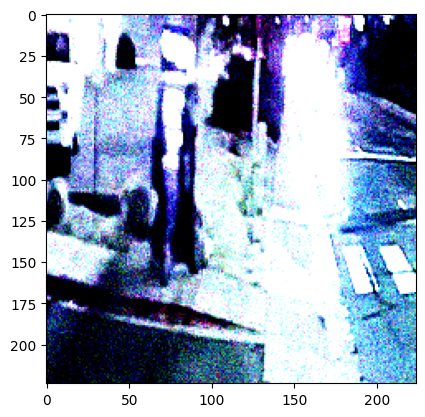

In [20]:
brightness_factor = 0.5
# adjusted_img = adjust_brightness(inputs[0,0], np.random.uniform(1-brightness_factor, 1+brightness_factor))
contrast_factor = 0.5
noise_factor = 0.2
# adjusted_img = adjust_contrast(inputs[0,0], np.random.uniform(1-contrast_factor, 1+contrast_factor))
adjusted_img = inputs[0,0] + torch.randn_like(inputs[0,0]) * noise_factor
# adjusted_img = inputs[0,0]
# adjusted_img = hflip(inputs[0,0])
# adjusted_img = adjust_hue(inputs[0,0],0.2)
# adjusted_img = inputs[0,0] + torch.randn_like(inputs[0,0]) * 0.2
plt.imshow(adjusted_img.permute(1,2,0).cpu().numpy())
plt.show()

In [7]:
precision, recall

(0.6521739130434783, 0.7142857142857143)

### Inference

In [1]:
from Dataset import VideoDataset,custom_transform,create_data_loaders,extract_optical_flow
from Model import ResNetLSTM,ResNetLSTMWithAttention
from Dataset import VideoDataset,custom_transform,create_data_loaders
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import *
from torchvision import models
from MotionAppearanceFusion import TwoStreamModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
model = TwoStreamModel().to(device)

In [3]:
# load the video, and screen the video to the region of interest, and extract the optical flow, then make a prediction list
def generate_tensors(model, video_path, pt1, pt2, device):
    # Load video frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.array(frames) # (seq_len, h, w, c)
    optical_flow_frames = extract_optical_flow(pt1, pt2, video_path)
    return frames, optical_flow_frames
    

In [ ]:
model_path = r"D:\LiDAR_Data\2ndPHB\Video\left_signal_0106\model\best_model.pth" 
model = TwoStreamModel().to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()

In [121]:
def compute_optical_flow(prev_gray, next_gray):
    flow = cv2.calcOpticalFlowFarneback(
    prev_gray, next_gray, None, 
    0.5, 3, 15, 3, 5, 1.2, 0
)
# Compute magnitude and angle
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
# Normalize magnitude
    normalized_magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)
# Encode angle into sine and cosine
    sin_angle = np.sin(angle)
    cos_angle = np.cos(angle)
# Stack the normalized magnitude, sin and cos angle
    optical_flow = np.stack([normalized_magnitude, sin_angle, cos_angle], axis=-1)
    return optical_flow
def custom_transform(frames):
    """ Normalize frames (batch_size, seq_len, h, w, c) """
    # to tensor
    frames = torch.tensor(frames)
    frames = frames / 255.0  # Scale pixel values to [0, 1]
    mean = torch.tensor([0.485, 0.456, 0.406])  # Imagenet mean for RGB
    std = torch.tensor([0.229, 0.224, 0.225])  # Imagenet std for RGB
    frames = (frames - mean) / std  # Normalize
    frames = frames.to(torch.float32).permute(0,3,1,2).unsqueeze(0)
    # # resize to 224x224
    # frames = torch.nn.functional.interpolate(frames.permute(0,3,1,2), size=224, mode = 'bilinear', align_corners=False)
    return frames

def predict(model, frames, optical_flow_frames, device):
    frames = np.array(frames)[1:]
    optical_flow_frames = np.array(optical_flow_frames)
    model.eval()
    with torch.no_grad():
        frames = custom_transform(frames).to(device)
        optical_flow_frames = torch.tensor(optical_flow_frames).permute(0, 3, 1, 2).unsqueeze(0).float().to(device)
        # print(frames.shape,optical_flow_frames.shape)
        outputs = model(frames, optical_flow_frames)
        outputs = torch.flatten(outputs)
        return outputs.cpu().numpy()

In [ ]:
# 1. sample more data clips from a label 
# 2. increase the data augmentation

In [124]:
pt1 = (450, 750)
pt2 = (750, 950)
# video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241208_075500.avi'
# save_path  = r'D:\LiDAR_Data\2ndPHB\Video\test.mp4'
video_list = os.listdir(r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo')
video_save_folder = r'D:\LiDAR_Data\2ndPHB\Video\L_signal_output'
os.makedirs(video_save_folder, exist_ok=True)
prediction_save_folder = r'D:\LiDAR_Data\2ndPHB\Video\L_signal_prediction'
os.makedirs(prediction_save_folder, exist_ok=True)
for video_name in tqdm(video_list):
    video_path = os.path.join(r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo',video_name)
    # save as mp4 format
    save_path = os.path.join(video_save_folder, video_name.replace('.avi','.mp4'))
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (raw_video_width, raw_video_height))
    frame_num = 35 # number of frames to predict
    # do prediction in each 35 frames
    prediction_sequence = [] # store the predicted vectors
    ret, cur_frame = cap.read()
    cur_raw_frame = cur_frame.copy()
    cur_frame = cur_frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    cur_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
    cur_frame_gray = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
    frames_rgb = [cur_frame_rgb]
    optical_frames = []
    for i in range(1,frame_num):
        ret, frame = cap.read()
        cur_raw_frame = frame.copy()
        if not ret:
            break
        # crop the frame
        frame = frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # compute optical flow
        optical_flow = compute_optical_flow(cur_frame_gray, frame_gray)
        frames_rgb.append(frame_rgb)
        optical_frames.append(optical_flow)
    prediction = predict(model, frames_rgb, optical_frames, device)
    # plot prediction value in right bottom corner of the raw frame and write to the video
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)
    line_type = 2
    cv2.putText(cur_raw_frame, str(prediction), (pt2[0], pt2[1]), font, font_scale, font_color, line_type)
    out.write(cur_raw_frame)

    prediction_sequence.append(prediction)

    # p_bar = tqdm(total=total_frames - frame_num)
    while cap.isOpened():
        ret, cur_frame = cap.read()
        if not ret:
            break
        cur_raw_frame = cur_frame.copy()
        cur_frame = cur_frame[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        cur_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
        cur_frame_gray = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
        frames_rgb.pop(0)
        frames_rgb.append(cur_frame_rgb)
        optical_frames.pop(0)
        optical_flow = compute_optical_flow(cur_frame_gray, frame_gray)
        optical_frames.append(optical_flow)
        
        prediction = predict(model, frames_rgb, optical_frames, device)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        line_type = 2
        cv2.putText(cur_raw_frame, str(prediction[0]), (pt2[0], pt2[1]), font, font_scale, font_color, line_type)
        out.write(cur_raw_frame)

        prediction_sequence.append(prediction)
        # p_bar.update(1)
    cap.release()
    out.release()
    # save the prediction sequence
    prediction_sequence = np.array(prediction_sequence)
    save_name = os.path.join(prediction_save_folder, video_name.replace('.avi','.npy'))
    np.save(save_name, prediction_sequence)

  3%|▎         | 43/1236 [3:40:49<102:06:34, 308.13s/it]


KeyboardInterrupt: 

In [118]:
out.release()

In [116]:
cur_raw_frame_ = cv2.putText(cur_raw_frame, str('prediction[0]'), (pt2[0], pt2[1]), font, 5, font_color, 10)

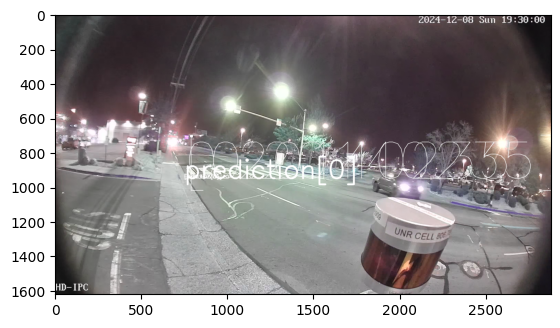

In [117]:
plt.imshow(cur_raw_frame_)

In [84]:
prediction_sequence = np.array(prediction_sequence)
prediction_sequence = prediction_sequence.flatten()

In [88]:
save_path = r"D:\LiDAR_Data\2ndPHB\Video\prediction_res.mp4"

In [ ]:
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (100, 100))
for frame in frames:
    out.write(frame)
out.release()

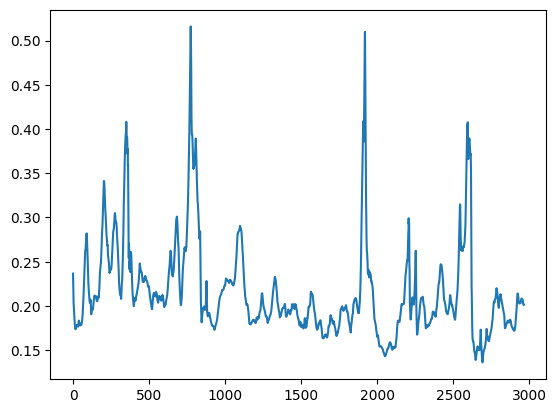

In [86]:
plt.plot(prediction_sequence)
plt.show()